**Task 1 - Distillation:**

**Use a resnet18 as the default “large” network and train it for N epochs**

**Import Libraries**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 


Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping the File

In [3]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/imagewoof2-160.tgz", "/content")

Data augmentation and normalization for training and Just normalization for validation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/imagewoof2-160'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking a Sample Image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


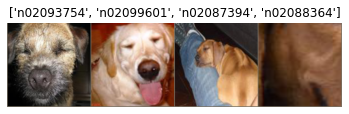

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Use a 5 layer CNN as the “small” network (use the convolution blocks with
normalisation and activations from the NN homework)**

In [ ]:
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/imagewoof2-160.tgz", "/content")

Use a 5 layer CNN as the “small” network (use the convolution blocks with
normalisation and activations from the NN homework)

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

In [ ]:
CLASSES, gems = [], [] 

for root, dirs, files in os.walk(r'/content/imagewoof2-160'):
    f = os.path.basename(root)       
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) 

    
gems_count = len(CLASSES)
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))


11 classes with 12955 images in total


In [ ]:
img_w, img_h = 220, 220  
train_dir = '/content/imagewoof2-160/train/'

In [ ]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)             
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))     
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [ ]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):   
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [ ]:

#Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)


In [ ]:
#Train_Lbls = get_class_index(Train_Lbls)
#print('Shape of train images: {}'.format(Train_Imgs.shape))
#print('Shape of train labels: {}'.format(Train_Lbls.shape))

In [ ]:
test_dir = '/content/imagewoof2-160/val/'

In [ ]:
X_train, y_train = read_imgs_lbls(train_dir)

In [ ]:
y_train = get_class_index(y_train)

In [ ]:
X_test, y_test = read_imgs_lbls(test_dir)

In [ ]:
y_test = get_class_index(y_test)

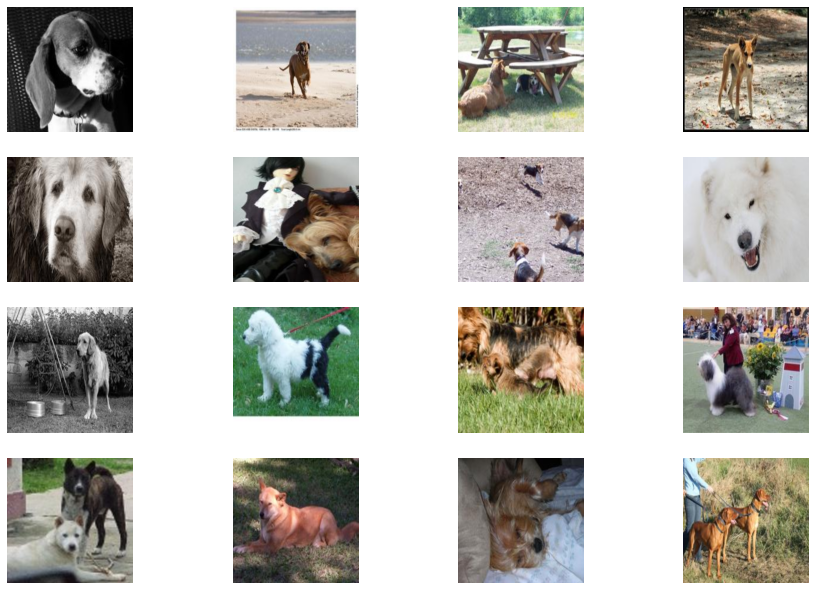

In [ ]:
dim = 4 

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(X_train))
        cl = y_train[rnd_number]
        ax[i,j].imshow(X_train[rnd_number])
        ax[i,j].axis('off')

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.4, random_state = 42)
#print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
#print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1)



In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=5,input_shape=(330, 330, 3), activation = 'relu'))
model.add(Conv2D(32, kernel_size=5, activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=3,activation = 'relu'))
model.add(Conv2D(64, kernel_size=3,activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=3, activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(11, activation = "softmax"))

In [ ]:

optimizer=Adam(lr=0.001)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 326, 326, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 322, 322, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 161, 161, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 161, 161, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 161, 161, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 159, 159, 64)      1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_try = model.fit(X_train,y_train, epochs = 3, validation_data = (X_test,y_test))

Epoch 1/3
283/283 [==============================] - 237s 773ms/step - loss: 12.2939 - accuracy: 0.1107 - val_loss: 2.3679 - val_accuracy: 0.1021
Epoch 2/3
283/283 [==============================] - 213s 753ms/step - loss: 2.4354 - accuracy: 0.1038 - val_loss: 2.3464 - val_accuracy: 0.1021
Epoch 3/3
283/283 [==============================] - 212s 751ms/step - loss: 2.3976 - accuracy: 0.1065 - val_loss: 2.3357 - val_accuracy: 0.1018


In [ ]:
model.save('/content/drive/MyDrive/cnnt2.h5')

Compare the following experiments:

○ Distilling the pretrained resnet18 into a small network (the small network is
not pretrained)

■ Train the resnet18 for N epochs to get resnet18 baseline

■ Train the small network for N epochs to get small network baseline

■ Compare these 2 baseline with the distilled small network 

Import Libraries

In [ ]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torch import nn, optim
import os

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,  
                                0.406], [0.229, 0.224, 0.225])])
trainset = '/content/imagewoof2-160/train'
valset = '/content/imagewoof2-160/val'

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,  
                                0.406], [0.229, 0.224, 0.225])])
trainset = datasets.CIFAR10('/content/imagewoof2-160/train', download=True, train=True, transform=transform)
valset = datasets.CIFAR10('/content/imagewoof2-160/val', download=True, train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/imagewoof2-160/train/cifar-10-python.tar.gz to /content/imagewoof2-160/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/imagewoof2-160/val/cifar-10-python.tar.gz to /content/imagewoof2-160/val


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
len_trainset = len(trainset)
len_valset = len(valset)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
   param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters())

In [ ]:
def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs=25):
   model.train()
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0
   for epoch in range(num_epochs):
      model.train()
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in trainloader:
         inputs = inputs.to(device)
         labels = labels.to(device)
         optimizer.zero_grad()
         outputs = model(inputs)
         loss = criterion(outputs, labels)
         _, preds = torch.max(outputs, 1)
         loss.backward() 
         optimizer.step()  
         running_loss += loss.item() * inputs.size(0)
         running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len_trainset
      epoch_acc = running_corrects.double() / len_trainset
      print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,
             epoch_acc)) 
         
      model.eval()
      running_loss_val = 0.0 
      running_corrects_val = 0
      for inputs, labels in valloader:
         inputs = inputs.to(device)
         labels = labels.to(device)
         outputs = model(inputs) 
         loss = criterion(outputs,labels)
         _, preds = torch.max(outputs, 1)
         running_loss_val += loss.item() * inputs.size(0)
         running_corrects_val += torch.sum(preds == labels.data)
      
      epoch_loss_val = running_loss_val / len_valset
      epoch_acc_val = running_corrects_val.double() / len_valset
      
      if epoch_acc_val > best_acc:
         best_acc = epoch_acc_val
         best_model_wts = copy.deepcopy(model.state_dict())
      
      print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val,
             epoch_acc_val))
      
      print()
      print('Best val Acc: {:4f}'.format(best_acc))
      model.load_state_dict(best_model_wts)
      return model

In [ ]:
resnet_teacher = train_and_evaluate(resnet,trainloader,
                                   valloader,criterion,optimizer,
                                   len_trainset,len_valset,10)

Epoch 0/9
----------
Train Loss: 0.8308 Acc: 0.7322
Val Loss: 0.6307 Acc: 0.7879

Best val Acc: 0.787900


In [ ]:
class Net(nn.Module):

   def __init__(self):
      super(Net, self).__init__()
      self.layer1 = nn.Sequential(
         nn.Conv2d(3, 64, kernel_size = (3,3), stride = (1,1), 
         padding = (1,1)),
         nn.ReLU(inplace=True),
         nn.Conv2d(64, 64, kernel_size = (3,3), stride = (1,1), 
         padding = (1,1)),
         nn.ReLU(inplace=True),
         nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
         dilation=1, ceil_mode=False)
      )
      self.layer2 = nn.Sequential(
         nn.Conv2d(64, 128, kernel_size = (3,3), stride = (1,1), 
         padding = (1,1)),
         nn.ReLU(inplace=True),
         nn.Conv2d(128, 128, kernel_size = (3,3), stride = (1,1), 
         padding = (1,1)),
         nn.ReLU(inplace=True),
         nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
         dilation=1, ceil_mode=False)
      )
      self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
      self.fc1 = nn.Linear(128, 32)
      self.fc2 = nn.Linear(32, 10)
      self.dropout_rate = 0.5
   
   def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.pool1(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      x = self.fc2(x)
      return x
net = Net().to(device)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
out = net(images.cuda())
print(out.shape)

In [ ]:
def loss_kd(outputs, labels, teacher_outputs, temparature, alpha):
   KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temparature, 
             dim=1),F.softmax(teacher_outputs/temparature,dim=1)) * (alpha * temparature * temparature) + F.cross_entropy(outputs, labels) * (1. - alpha)
   return KD_loss
def get_outputs(model, dataloader):

   outputs = []
   for inputs, labels in dataloader:
      inputs_batch, labels_batch = inputs.cuda(), labels.cuda()
      output_batch = model(inputs_batch).data.cpu().numpy()
      outputs.append(output_batch)
   return outputs

In [ ]:
def train_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
   model.train()
   running_loss = 0.0
   running_corrects = 0
   for i,(images, labels) in enumerate(dataloader):
      inputs = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      outputs_teacher = torch.from_numpy(teacher_out[i]).to(device)
      loss = loss_kd(outputs,labels,outputs_teacher,temparature, 
                     alpha)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
   
   epoch_loss = running_loss / len(trainset)
   epoch_acc = running_corrects.double() / len(trainset)
   print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, 
          epoch_acc))
def eval_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
   model.eval()
   running_loss = 0.0
   running_corrects = 0
   for i,(images, labels) in enumerate(dataloader):
      inputs = images.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      outputs_teacher = torch.from_numpy(teacher_out[i]).cuda()
      loss = loss_kd(outputs,labels,outputs_teacher,temparature, 
                     alpha)
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
   epoch_loss = running_loss / len(valset)
   epoch_acc = running_corrects.double() / len(valset)
   print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,
          epoch_acc))
   return epoch_acc
def train_and_evaluate_kd(model, teacher_model, optimizer, loss_kd, trainloader, valloader, temparature, alpha, num_epochs=25):
   teacher_model.eval()
   best_model_wts = copy.deepcopy(model.state_dict())
   outputs_teacher_train = get_outputs(teacher_model, trainloader)
   outputs_teacher_val = get_outputs(teacher_model, valloader)
   print('Teachers outputs are computed now starting the training process')
   best_acc = 0.0
   for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      
      train_kd(model, outputs_teacher_train, 
               optim.Adam(net.parameters()),loss_kd,trainloader, 
               temparature, alpha)
     
      epoch_acc_val = eval_kd(model, outputs_teacher_val,  optim.Adam(net.parameters()), loss_kd, 
                          valloader, temparature, alpha)
      if epoch_acc_val > best_acc:
         best_acc = epoch_acc_val
         best_model_wts = copy.deepcopy(model.state_dict())
         print('Best val Acc: {:4f}'.format(best_acc))
         model.load_state_dict(best_model_wts)
   return model

In [ ]:
stud=train_and_evaluate_kd(net,resnet_teacher,
optim.Adam(net.parameters()),loss_kd,trainloader,valloader,1,0.5,20)

 **Distilling the small network into itself (train the small network for M epochs,
create a new copy of the small network and distil the pretrained one into it for
M epochs, repeat the process X times)**

In [ ]:
import numpy as np
logits= np.array([0,1,0,0,0])
T=[0.05, 0.8, 0.2,0.05]
for t in T:
    logits_exp_norm= np.exp(logits)/sum(np.exp(logits))
    logits_exp_norm_with_T= np.exp(logits/t)/sum(np.exp(logits/t))
    print("with T=",t, logits_exp_norm_with_T)
print("softmax :", logits_exp_norm)

with T= 0.05 [2.06115361e-09 9.99999992e-01 2.06115361e-09 2.06115361e-09
 2.06115361e-09]
with T= 0.8 [0.13350524 0.46597906 0.13350524 0.13350524 0.13350524]
with T= 0.2 [0.00656111 0.97375555 0.00656111 0.00656111 0.00656111]
with T= 0.05 [2.06115361e-09 9.99999992e-01 2.06115361e-09 2.06115361e-09
 2.06115361e-09]
softmax : [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]


In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/imagewoof2-160.tgz", "/content")

In [ ]:
CLASSES, gems = [], [] 

for root, dirs, files in os.walk(r'/content/imagewoof2-160'):
    f = os.path.basename(root)       
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) 

    
gems_count = len(CLASSES)
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

11 classes with 12955 images in total


In [ ]:
img_w, img_h = 30, 30  
train_dir = '/content/imagewoof2-160/train/'

In [ ]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)             
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))     
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [ ]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):   
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [ ]:
test_dir = '/content/imagewoof2-160/val/'

In [ ]:
X_train, y_train = read_imgs_lbls(train_dir)

In [ ]:
y_train = get_class_index(y_train)

In [ ]:
X_test, y_test = read_imgs_lbls(test_dir)

In [ ]:
y_test = get_class_index(y_test)

In [ ]:
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_test: {}, y_test: {} '.format(X_test.shape, y_test.shape))

Shape of X_train: (9025, 45, 45, 3), y_train: (9025,) 
Shape of X_test: (3929, 45, 45, 3), y_test: (3929,) 


In [ ]:
teacher = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(45, 45, 3)),
        
        tf.keras.Input(shape=(45, 45, 3)),
        
        tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),

  
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
     


        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
     

        tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
    

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(11),
    ],
    name="teacher",
)
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 23, 23, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        1849

In [ ]:
# Create the student
student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(45, 45, 3)),
        
        tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),

  
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
     


        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
     

        tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.BatchNormalization(),
    

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(11),
    ],
    name="student",
)
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12, 12, 64)        0   

In [ ]:
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Train and evaluate teacher on data.
teacher.fit(X_train, y_train, epochs=1)
teacher.evaluate(X_test, y_test)

123/123 [==============================] - 1s 6ms/step - loss: 2.3225 - sparse_categorical_accuracy: 0.2555


[2.3224823474884033, 0.255535751581192]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn=student_loss_fn
        self.distillation_loss_fn= distillation_loss_fn
        self.temperature= temperature
        self.alpha= alpha
        
    def train_step(self, data):
        x,y=data
        
        # Forward pass of teacher
        teacher_prediction=self.teacher(x, training=False)
        print("Tecaher prediction   ...", teacher_prediction)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predcition= self.student(x, training=True)
            # Compute losses
            student_loss= self.student_loss_fn(y, student_predcition)
            
            distillation_loss=self.distillation_loss_fn(
            tf.nn.softmax(teacher_prediction/self.temperature, axis=1),
            tf.nn.softmax(student_predcition/self.temperature, axis=1)
            )
            loss= self.alpha* student_loss + (1-self.alpha)* distillation_loss
            print("Loss in distiller :",loss)
            # Compute gradients
            trainable_vars= self.student.trainable_variables
            gradients=tape.gradient(loss, trainable_vars)
            gradients = [gradient * (self.temperature ** 2) for gradient in gradients]
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Update the metrics configured in `compile()`
            self.compiled_metrics.update_state(y, student_predcition)
            
            # Return a dict of performance
            results={ m.name: m.result()  for m in self.metrics}
            results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
            print("Train...", results)
            return results
        
    def test_step(self, data):
        # Unpack the data
        x, y = data
        
        ## Compute predictions
        y_prediction= self.student(x, training=False)
        
        # calculate the loss
        student_loss= self.student_loss_fn(y, y_prediction)
        
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        
        # Return a dict of performance
        results ={m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        print("Test...", results)
        return results
# Initialize  distiller
distiller= Distiller(student=student, teacher=teacher)

In [ ]:
#compile distiller
distiller.compile(optimizer=keras.optimizers.Adam(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 distillation_loss_fn=keras.losses.KLDivergence(),
                 alpha=0.3,
                 temperature=7)

In [ ]:
# Distill teacher to student
distiller.fit(X_train, y_train, epochs=5)
# Evaluate student on test dataset
distiller.evaluate(X_test, y_test)

Epoch 1/5
Tecaher prediction   ... Tensor("teacher/dense/BiasAdd:0", shape=(None, 11), dtype=float32)
Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
Tecaher prediction   ... Tensor("teacher/dense/BiasAdd:0", shape=(None, 11), dtype=float32)
Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
283/283 [==============================] - 10s 23ms/step - sparse_categorical_accuracy: 0.2309 - s

[0.3324001133441925, 2.6133878231048584]